In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

## Initialize ensembles

In [2]:
n_ens = 5
n_ops = 5
ensembles = ['24I/ml_0p01', '24I/ml_0p005', '32I/ml0p008', '32I/ml0p006', '32I/ml0p004']
# labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
labels = ['O_1', 'O_2', 'O_3', 'O_1p', 'O_2p']
colors = ['r', 'g', 'b', 'c', 'y']
L_cfgs = [24, 24, 32, 32, 32]

# Lattice spacing and physical constants from PDG. Pairs are (value, error), and everything should be in GeV.
ainv_0 = np.array([[1.784, 0.005], [1.784, 0.005], [2.382, 0.008], [2.382, 0.008], [2.382, 0.008]], dtype=np.float64)
# Currently in GeV, but by convention alpha has units fm^-2, so pass in a^2 in fm^2

mpi_0 = (0.13957039, 1.8e-7)        # (value, error) in GeV
fpi_0 = (0.1302, 1.2e-3)

# # David's values for testing-- use PDG values after testing
# mpi_0   = [ 0.13957018, 0.00000035 ]
# fpi_0   = [ 0.13041, np.sqrt(0.00003**2 + 0.00020**2) ]

The following 3 cells each read in and format the data differently. For the first two cells, if I run these I should have uncommented the line 'n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]'. For the last cell (if I'm not doing another bootstrap), I should uncomment 'n_samples = [52, 53, 33, 42, 48]'. 
1. Reads in my data output, which is formatted in an hdf5 file and produced in Short-Distance-Plots-Fits.ipynb
2. Reads in David's data in Pi_Pi/config/fits/results/fit_params/xyz.dat, then bootstraps each data file with the same seed and returns the data as a well formated numpy array.
3. Reads in David's data in Pi_Pi/config/fits/results/fit_params/xyz.dat, but does not bootstrap it. The data is formatted as a list of arrays, each with varying size depending on n_samples.

#### (Option 1) Read in my data output

In [3]:
# Generate fake ensembles. TODO does it matter if I seed these or not? This is what is generating differences per run.
n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # uncomment if I separately bootstrap
ainv_ens = [gen_fake_ensemble(ainv_0[i], n_samples[i]) for i in range(n_ens)]
mpi_0_ens = [gen_fake_ensemble(mpi_0, n_samples[i]) for i in range(n_ens)]
fpi_0_ens = [gen_fake_ensemble(fpi_0, n_samples[i]) for i in range(n_ens)]
hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
asq_ens = [(ainv_ens[i] ** (-2)) * (hbarc ** 2) for i in range(n_ens)]   # generate a^2 ensemble in fm^2

mat_elems = [np.zeros((n_ops, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
mpi = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
fpi = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
eps_sq = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
eps_sq_phys = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
for ens_idx, config in enumerate(ensembles):
    path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/fits/' + config + '/fit_params.h5'
    f = h5py.File(path, 'r')
    a4_mat_elem = f['fits'][()]
    for i in range(n_ops):
        # TODO figure out this factor, David just throws it into the middle of his code and it changes the results
        mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
        # print(labels[i], mult_factor)
        mat_elems[ens_idx][i, :] = a4_mat_elem[:, i] * (ainv_ens[ens_idx][:] ** 4) * mult_factor    # restore units
    f.close()
    mpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/mpi_jacks.dat'
    a_mpi = np.genfromtxt(mpi_path)
    fpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/fpi_jacks.dat'
    a_fpi = np.genfromtxt(fpi_path)
    if config == '32I/ml0p004':
        err_idx = int((840 - 520) / 20)
        a_mpi = np.delete(a_mpi, err_idx)
        a_fpi = np.delete(a_fpi, err_idx)
    a_mpi_boot = bootstrap(a_mpi, data_type = np.float64)
    a_fpi_boot = bootstrap(a_fpi, data_type = np.float64)
    mpi_tmp = a_mpi_boot * ainv_ens[ens_idx]
    fpi_tmp = a_fpi_boot * ainv_ens[ens_idx]
    eps_sq_phys_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_0_ens[ens_idx]**2))
    eps_sq_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_tmp**2))
    mpi[ens_idx], fpi[ens_idx] = mpi_tmp, fpi_tmp
    eps_sq[ens_idx] = eps_sq_tmp
    eps_sq_phys[ens_idx] = eps_sq_phys_tmp

#### (Option 2) Read in David's data and bootstrap it.

In [ ]:
# # Generate fake ensembles. TODO does it matter if I seed these or not? This is what is generating differences per run.
# n_samples = [n_boot, n_boot, n_boot, n_boot, n_boot]    # uncomment if I separately bootstrap
# ainv_ens = [gen_fake_ensemble(ainv_0[i], n_samples[i]) for i in range(n_ens)]
# mpi_0_ens = [gen_fake_ensemble(mpi_0, n_samples[i]) for i in range(n_ens)]
# fpi_0_ens = [gen_fake_ensemble(fpi_0, n_samples[i]) for i in range(n_ens)]
# hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
# asq_ens = [(ainv_ens[i] ** (-2)) * (hbarc ** 2) for i in range(n_ens)]   # generate a^2 ensemble in fm^2

# mat_elems = [np.zeros((n_ops, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# mpi = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# fpi = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# eps_sq = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# eps_sq_phys = [np.zeros((n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     for i in range(n_ops):
#         Opath = '/Users/theoares/Pi_Pi/' + ensembles[ens_idx] + '/fits/results/fit_params/' + labels[i] + '_jacks.dat'
#         a4mat_elem = np.genfromtxt(Opath)
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         a4mat_elem_boot = bootstrap(a4mat_elem, data_type = np.float64)
#         mat_elems[ens_idx][i, :] = a4mat_elem_boot * (ainv_ens[ens_idx] ** 4) * mult_factor    # restore units
#     mpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/mpi_jacks.dat'
#     a_mpi = np.genfromtxt(mpi_path)
#     fpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/fpi_jacks.dat'
#     a_fpi = np.genfromtxt(fpi_path)
#     a_mpi_boot = bootstrap(a_mpi, data_type = np.float64)
#     a_fpi_boot = bootstrap(a_fpi, data_type = np.float64)
#     mpi_tmp = a_mpi_boot * ainv_ens[ens_idx]
#     fpi_tmp = a_fpi_boot * ainv_ens[ens_idx]
#     eps_sq_phys_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_0_ens[ens_idx]**2))
#     eps_sq_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_tmp**2))
#     mpi[ens_idx], fpi[ens_idx] = mpi_tmp, fpi_tmp
#     eps_sq[ens_idx] = eps_sq_tmp
#     eps_sq_phys[ens_idx] = eps_sq_phys_tmp

#### (Option 3) Read in David's data, do not bootstrap it (replicate his code)

In [ ]:
# # Generate fake ensembles. TODO does it matter if I seed these or not? This is what is generating differences per run.
# n_samples = [52, 53, 33, 42, 48]
# ainv_ens = [gen_fake_ensemble(ainv_0[i], n_samples[i]) for i in range(n_ens)]
# mpi_0_ens = [gen_fake_ensemble(mpi_0, n_samples[i]) for i in range(n_ens)]
# fpi_0_ens = [gen_fake_ensemble(fpi_0, n_samples[i]) for i in range(n_ens)]
# hbarc = 0.197326   # conversion from fm to GeV, in units GeV * fm
# asq_ens = [(ainv_ens[i] ** (-2)) * (hbarc ** 2) for i in range(n_ens)]   # generate a^2 ensemble in fm^2

# mat_elems = [np.zeros((n_ens, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# mpi = [np.zeros((n_ens, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# fpi = [np.zeros((n_ens, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# eps_sq = [np.zeros((n_ens, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# eps_sq_phys = [np.zeros((n_ens, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# for ens_idx, config in enumerate(ensembles):
#     for i in range(n_ops):
#         Opath = '/Users/theoares/Pi_Pi/' + ensembles[ens_idx] + '/fits/results/fit_params/' + labels[i] + '_jacks.dat'
#         a4mat_elem = np.genfromtxt(Opath)
#         mult_factor = 1 / 16 if i == 0 or i == 3 else 1 / 8    # random multiplication factor in David's code???
#         mat_elems[ens_idx][i, :] = a4mat_elem * (ainv_ens[ens_idx] ** 4) * mult_factor    # restore units
#     mpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/mpi_jacks.dat'
#     a_mpi = np.genfromtxt(mpi_path)
#     fpi_path = '/Users/theoares/Pi_Pi/' + config + '/fits/results/fit_params/fpi_jacks.dat'
#     a_fpi = np.genfromtxt(fpi_path)
#     mpi_tmp = a_mpi * ainv_ens[ens_idx]
#     fpi_tmp = a_fpi * ainv_ens[ens_idx]
#     eps_sq_phys_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_0_ens[ens_idx]**2))
#     eps_sq_tmp = (mpi_tmp**2) / (8 * (np.pi**2) * (fpi_tmp**2))
#     mpi[ens_idx], fpi[ens_idx] = mpi_tmp, fpi_tmp
#     eps_sq[ens_idx] = eps_sq_tmp
#     eps_sq_phys[ens_idx] = eps_sq_phys_tmp

In [4]:
# generate information in tables 2 and 3-- get the mean and STD of bootstrapped ensembles
print('Running statistics with physical units')
mat_elem_mu = [np.mean(mat_elems[i], axis = 1) for i in range(n_ens)]
mat_elem_sigma = [np.std(mat_elems[i], axis = 1, ddof = 1) for i in range(n_ens)]
mpi_mu = [np.mean(mpi[i]) for i in range(n_ens)]
mpi_sigma = [np.std(mpi[i], ddof = 1) for i in range(n_ens)]
fpi_mu = [np.mean(fpi[i]) for i in range(n_ens)]
fpi_sigma = [np.std(fpi[i], ddof = 1) for i in range(n_ens)]
eps_mu = [np.mean(eps_sq[i]) for i in range(n_ens)]
eps_sigma = [np.std(eps_sq[i], ddof = 1) for i in range(n_ens)]
eps_phys_mu = [np.mean(eps_sq_phys[i]) for i in range(n_ens)]
eps_phys_sigma = [np.std(eps_sq_phys[i], ddof = 1) for i in range(n_ens)]
ainv_ens_mu = [np.mean(ainv_ens[i]) for i in range(n_ens)]
ainv_ens_sigma = [np.std(ainv_ens[i], ddof = 1) for i in range(n_ens)]
asq_ens_mu = [np.mean(asq_ens[i]) for i in range(n_ens)]
asq_ens_sigma = [np.std(asq_ens[i], ddof = 1) for i in range(n_ens)]

for ens_idx in range(n_ens):
    print(ensembles[ens_idx])
    print('a^-1 = ' + str(ainv_ens_mu[ens_idx]) + ' \pm ' + str(ainv_ens_sigma[ens_idx]) + ' GeV')
    print('a^2 = ' + str(asq_ens_mu[ens_idx]) + ' \pm ' + str(asq_ens_sigma[ens_idx]) + ' fm^2')
    print('m_pi: ' + str(mpi_mu[ens_idx]) + ' \pm ' + str(mpi_sigma[ens_idx]) + ' GeV')
    print('f_pi: ' + str(fpi_mu[ens_idx]) + ' \pm ' + str(fpi_sigma[ens_idx]) + ' GeV')
    print('epsilon_pi_sq: ' + str(eps_mu[ens_idx]) + ' \pm ' + str(eps_sigma[ens_idx]))
    print('epsilon_pi_phys_sq (to plot at): ' + str(eps_phys_mu[ens_idx]) + ' \pm ' + str(eps_phys_sigma[ens_idx]))
    for op_idx in range(n_ops):
        print(labels[op_idx]+': '+str(mat_elem_mu[ens_idx][op_idx])+' \pm '+str(mat_elem_sigma[ens_idx][op_idx]) \
              + ' (GeV)^4')
    print('\n')

Running statistics with physical units
24I/ml_0p01
a^-1 = 1.7848400624570302 \pm 0.004852228659107614 GeV
a^2 = 0.012223046725082615 \pm 6.663093161532003e-05 fm^2
m_pi: 0.4312245067955196 \pm 0.0011720271946724296 GeV
f_pi: 0.16380061834974288 \pm 0.00044517297773589027 GeV
epsilon_pi_sq: 0.08777807776926769 \pm 1.2155315418038337e-05
epsilon_pi_phys_sq (to plot at): 0.1385209048236702 \pm 0.001734958570702879
O_1: -0.029437209159010415 \pm 0.00038715977574547923 (GeV)^4
O_2: -0.10142029080667028 \pm 0.0014566373466556035 (GeV)^4
O_3: 0.0035100218072339645 \pm 4.420405551321353e-05 (GeV)^4
O_1p: -0.09096383475469715 \pm 0.0012023948630371338 (GeV)^4
O_2p: 0.024747665704142087 \pm 0.00035556984055445647 (GeV)^4


24I/ml_0p005
a^-1 = 1.7848400624570302 \pm 0.004852228659107614 GeV
a^2 = 0.012223046725082615 \pm 6.663093161532003e-05 fm^2
m_pi: 0.3414545440859159 \pm 0.0009250076012041194 GeV
f_pi: 0.1516285135326579 \pm 0.00041205157940983476 GeV
epsilon_pi_sq: 0.06422651118960764 \pm 1

David is multiplying $a_{inv}^4 * <pi|O|pi>$ by seemingly random numbers in the chiral extrapolation file. He's multiplying:
O1 and O1p matrix element by 0.0625 = 1/16
O2, O3, and O2p matrix elements by 0.125 = 1/8

For $\epsilon_\pi^2$, my numbers match what David's code outputs. It doesn't seem like that's what he's plotting against though in the chiral extrapolation plot-- I believe he's plotting against $\epsilon_\pi^2$, evaluated with $f_\pi$ at the physical point (when I plotted these points they looked like they were at the same $\epsilon^2$ value). 

Order of ensembles on plot:
32I/ml0p004
24I/ml_0p005
32I/ml0p006
32I/ml0p008
24I/ml_0p01

The fit that David is doing is a little different than what I've been doing-- I'll detail the two ways in my notes. The difference comes down to the fact that the data points we're fitting to in this case should be uncorrelated, since the distributions are generated differently at each $\epsilon^2$ value (i.e. configuration 1200 for 24I/ml_0p01 and for 24I/ml_0p005 should have no correlation with one another because they're generated independently).

TODO: do the statistics properly-- namely, I need to be better about:
1. Computing the fake ensembles. There is some commented code to do it propertly, but right now I'm generating each bootstrap sample in the same way and then using np.std to get errors on it. 
2. Errors on bootstrapped objects should be computed in a different way-- instead of taking the np.std along the boot axis, I need to factor in the other data as well. David's code does this in compute_std(), so I'll need to figure out what it's doing and be more precise about how I'm computing my errors. Right now, it should be close, but it's probably not the right way to do it. Once this is figured out, I should switch out how I'm generating the fake data as well to what I have commented out in the gen_fake_data() function.

<IPython.core.display.Javascript object>


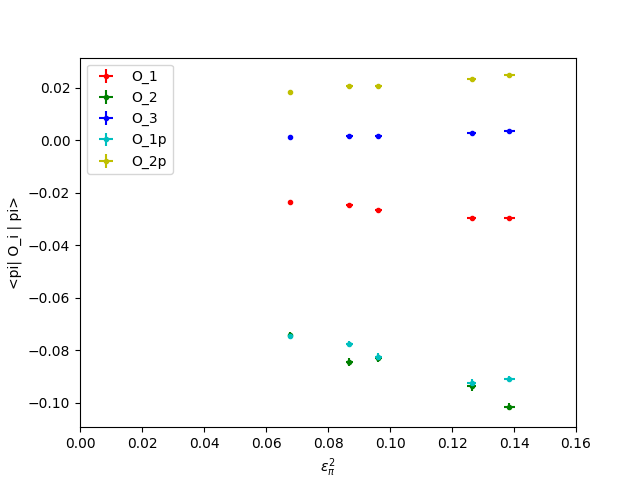

In [5]:
# Plot data points. This shouldn't match up with David's graph, that graph is plotting these points after subtracting the fit off
plt.figure()
for i in range(n_ops):
    plt.errorbar(eps_phys_mu, [mat_elem_mu[j][i] for j in range(n_ens)], xerr = eps_phys_sigma, yerr = [mat_elem_sigma[j][i] for j in range(n_ens)], fmt = '.', c = colors[i], label = labels[i])
plt.xlabel('$\epsilon_\pi^2$')
plt.ylabel('<pi| O_i | pi>')
plt.legend()
plt.xlim((0, 0.16))
# plt.ylim((-0.08, 0.02))
plt.show()

In [6]:
def f0(m, L, ainv):
    f0 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f0 += -2 * kn(0, (m / ainv) * L * n)
    return f0
def f1(m, L, ainv):
    f1 = 0
    for n1, n2, n3 in itertools.product(range(L), repeat = 3):
        if n1 == 0 and n2 == 0 and n3 == 0:
            continue
        n = np.sqrt(float(n1) ** 2 + float(n2) ** 2 + float(n3) ** 2)
        f1 += 4 * kn(1, (m / ainv) * L * n) / ((m / ainv) * L * n)
    return f1
# for O1, O2, O1p, O2p, fv = -f0 + 2*f1, for O3 fv = f0 + 2*f1
# TODO: David only inputs L = 32 for the f1 piece-- seems like a bug???
def get_fv_fn(op_idx):
    if op_idx == 2:    # for O3
        return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, L, ainv)
    return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, L, ainv)
#     if op_idx == 2:    # for O3
#         return lambda m, L, ainv : f0(m, L, ainv) + 2 * f1(m, 32, ainv)
#     return lambda m, L, ainv : -f0(m, L, ainv) + 2 * f1(m, 32, ainv)

In [7]:
# Define functional fit forms for the operators (these agree with David's functions)
def O1(a1, b1, c1, m, f, a_sq, fv):    # a_lat should be in GeV^-1, 
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m ** 2) / Lam_sq
    return b1*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c1 + fv) + a1 * a_sq)
def O2(a2, b2, c2, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return b2*Lam_sq**2/(16*np.pi**2) * (1 + e_sq * (np.log(e_sq) - 1 + c2 + fv) + a2 * a_sq)
def O3(a3, b3, c3, m, f, a_sq, fv):
    Lam_sq = 8 * (np.pi**2) * (f**2)
    e_sq = (m**2) / Lam_sq
    return e_sq * b3*Lam_sq**2/(16*np.pi**2) * (1 - e_sq*(3*np.log(e_sq) + 1 - c3 + fv) + a3 * a_sq)
def get_chi2(O_fn):
    def chi2(x, m, f, a_sq, fv, O_val, dO):    # x should be (alpha, beta, c), the fit params to get
        val = 0.0
        for j in range(n_ens):
            val += (O_fn(x[0], x[1], x[2], m[j], f[j], a_sq[j], fv[j]) - O_val[j]) ** 2 / (dO[j] ** 2)
        return val
    return chi2
O_list = [O1, O2, O3, O1, O2]
chi2_list = [get_chi2(Oi) for Oi in O_list]

In [8]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
    O_elems = np.array([mat_elem_mu[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    O_elems_sigma = np.array([mat_elem_sigma[ens_idx][op_idx] for ens_idx in range(n_ens)], dtype = np.float64)
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_mu, fpi_mu, asq_ens_mu, \
            fv_list, O_elems, O_elems_sigma), method = 'Powell', options = {'maxiter':10000, 'ftol':1.0e-08})
    guesses1[op_idx, :] = out['x'][:]

0
1
2
3
4


In [9]:
# the difference in fits to mean each time I run them is due to uncertainty in the lattice spacing, since I haven't 
# seeded the random number generator for the fake ensembles
print('Results of fits to mean:')
print('α | β | c')
for i in range(n_ens):
    print(labels[i])
    print(guesses1[i])

Results of fits to mean:
α | β | c
O_1
[-1.7047779  -1.70162131 -0.77977649]
O_2
[ 9.91176808 -4.90978854 -1.04174225]
O_3
[50.64853719  0.6100836   1.41947524]
O_1p
[-1.8761301  -5.46803777 -1.02076862]
O_2p
[ 7.14699031  1.25321769 -1.02528061]


In [ ]:
alpha = [np.zeros((n_ops, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
beta = [np.zeros((n_ops, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
c = [np.zeros((n_ops, n_samples[i]), dtype = np.float64) for i in range(n_ens)]
# alpha = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
# beta = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
# c = np.zeros((n_ops, n_ens, n_boot), dtype = np.float64)
for op_idx in range(n_ops):
    print('Operator ' + labels[op_idx])
    fv = get_fv_fn(op_idx)
    guess = guesses1[op_idx]
    O_sigma = np.array([mat_elem_sigma[i][op_idx] for i in range(n_ens)])    # uncertainty doesn't change per boot idx
    for ens_idx in range(n_ens):
        for b_idx in range(n_samples[ens_idx]):
            print('Ensemble ' + str(ens_idx) + ', boot ' + str(b_idx))
            m_boot = np.array([mpi[ens_idx][b_idx] if i == ens_idx else mpi_mu[i] for i in range(n_ens)])
            f_boot = np.array([fpi[ens_idx][b_idx] if i == ens_idx else fpi_mu[i] for i in range(n_ens)])
            ainv_boot = np.array([ainv_ens[ens_idx][b_idx] if i == ens_idx else ainv_ens_mu[i] for i in range(n_ens)])
            asq_boot = np.array([asq_ens[ens_idx][b_idx] if i == ens_idx else asq_ens_mu[i] for i in range(n_ens)])
            fv_boot = np.array([fv(m_boot[ens_idx], L_cfgs[ens_idx], ainv_boot[ens_idx]) for ens_idx in range(n_ens)])
            O_boot = np.array([mat_elems[ens_idx][op_idx, b_idx] if i == ens_idx else mat_elem_mu[i][op_idx] \
                               for i in range(n_ens)])
            out = optimize.minimize(chi2_list[op_idx], guess, args = (m_boot, f_boot, asq_boot, fv_boot, O_boot, \
                                        O_sigma), method = 'Powell', options = {'maxiter' : 10000, 'ftol' : 1.0e-08})
            print(out['x'])
            alpha[ens_idx][op_idx, b_idx] = out['x'][0]
            beta[ens_idx][op_idx, b_idx] = out['x'][1]
            c[ens_idx][op_idx, b_idx] = out['x'][2]
#             alpha[op_idx, ens_idx, b_idx] = out['x'][0]
#             beta[op_idx, ens_idx, b_idx] = out['x'][1]
#             c[op_idx, ens_idx, b_idx] = out['x'][2]

In [ ]:
# Right now: running david's data with buggy code (using L = 32 everywhere in f1)

In [ ]:
# def compute_boot_sigma(x):
#     var = np.sum(np.std(x, axis = 1, ddof = 1) ** 2)
#     return np.sqrt(var)
# alpha_mu = np.mean(alpha, axis = (1, 2))
# alpha_sigma = np.std(alpha, axis = (1, 2), ddof = 1)
alpha_mu = superboot_mean(alpha)
alpha_sigma = superboot_std(alpha)
beta_mu = superboot_mean(beta)
beta_sigma = superboot_std(beta)
c_mu = superboot_mean(c)
c_sigma = superboot_std(c)
for op_idx in range(n_ops):
    print('Fit parameters for operator ' + labels[op_idx])
    print('alpha = ' + str(alpha_mu[op_idx]) + ' \pm ' + str(alpha_sigma[op_idx]))
    print('beta = ' + str(beta_mu[op_idx]) + ' \pm ' + str(beta_sigma[op_idx]))
    print('c = ' + str(c_mu[op_idx]) + ' \pm ' + str(c_sigma[op_idx]))

TODO: Do the statistics properly and reproduce David's data

Results of fits to mean:
α | β | c
O_1
[-1.6776341  -1.70318909 -0.78263887]
O_2
[ 9.8426166  -4.94903776 -1.09693305]
O_3
[51.12373925  0.6039983   1.63291869]
O_1p
[-1.91554756 -5.48251005 -1.03250114]
O_2p
[ 7.07811846  1.26249626 -1.07270414]

Results I get from David's data with the actual L value in the fit:
Fit parameters for operator O_1
alpha = -1.6772886834355787 \pm 0.36176496783264084
beta = -1.7031549567884 \pm 0.008641730443813707
c = -0.7825559946631809 \pm 0.06369359304930194
Fit parameters for operator O_2
alpha = 9.84303941413853 \pm 0.4352151528767927
beta = -4.948949695858259 \pm 0.028990733953735
c = -1.0968321178851779 \pm 0.07335183915029161
Fit parameters for operator O_3
alpha = 51.124601348377496 \pm 0.8206064383011301
beta = 0.6039914307668391 \pm 0.004326694000191481
c = 1.6332262757835327 \pm 0.1605487625517945
Fit parameters for operator O_1p
alpha = -1.9151985772470883 \pm 0.36146844524629146
beta = -5.482401444207083 \pm 0.027658826737777465
c = -1.0324260580728521 \pm 0.06273048098734392
Fit parameters for operator O_2p
alpha = 7.0785135611754955 \pm 0.4124247750229582
beta = 1.2624728689698481 \pm 0.007102806310247535
c = -1.0726060085857516 \pm 0.07008884218392306

Results I get from David's data with the L = 32 in f1:
Results of fits to mean:
α | β | c
O_1
[-1.40786147 -1.7071541  -0.82773036]
O_2
[10.08483741 -4.96465483 -1.14992695]
O_3
[51.42657621  0.60297522  1.60885505]
O_1p
[-1.65489154 -5.4968945  -1.07768351]
O_2p
[ 7.34274625  1.26623873 -1.12598374]


Fit parameters for operator O_1
alpha = -1.4092798722985869 \pm 0.3621874239710354
beta = -1.7034833051650018 \pm 0.008663484413586178
c = -0.811047608009493 \pm 0.06385930303708255
Fit parameters for operator O_2
alpha = 10.10770924063631 \pm 0.43663337091766186
beta = -4.94899942244155 \pm 0.029083066500162666
c = -1.1233105823853 \pm 0.0736563652976296
Fit parameters for operator O_3
alpha = 50.831133317080294 \pm 0.8178209743898698
beta = 0.604129578837595 \pm 0.004322291452129964
c = 1.6564903496592027 \pm 0.16014746260540136
Fit parameters for operator O_1p
alpha = -1.6485344377803215 \pm 0.3618635621075172
beta = -5.483571788942106 \pm 0.027731259808897346
c = -1.0608887573928638 \pm 0.06289562400095784
Fit parameters for operator O_2p
alpha = 7.343412990167769 \pm 0.41366887019105564
beta = 1.2625400841043732 \pm 0.0071256499420115586
c = -1.0995389752984426 \pm 0.07036896467787825

## My results to compare against (don't delete)

Results of fits to mean (proper value of L used for fv):
α | β | c
O1
[-1.10385333 -1.70511562 -0.8658774 ]
O2
[10.42778075 -4.94021028 -1.15838303]
O3
[51.71249396  0.60791508  1.44638675]
O1p
[-1.27907625 -5.48134644 -1.10904817]
O2p
[ 7.63755571  1.2605756  -1.13336181]

My results using proper value of L for fv:

Results of fits to mean:
α | β | c
O_1
[-1.23405775 -1.71135976 -0.88020083]
O_2
[10.38162491 -4.95714225 -1.18495019]
O_3
[51.65114568  0.60644883  1.51080356]
O_1p
[-1.42442085 -5.50191717 -1.12091593]
O_2p
[ 7.61408292  1.2647432  -1.16100325]

Fit parameters for operator O_1
alpha = -1.2328243599413784 \pm 0.7445168896593265
beta = -1.7113207061649944 \pm 0.02186327293787101
c = -0.8799725419871367 \pm 0.12784950908111187
Fit parameters for operator O_2
alpha = 10.3840009462502 \pm 1.3231485231936444
beta = -4.9570483649791255 \pm 0.10681902965800048
c = -1.184258799349267 \pm 0.21694772242645147
Fit parameters for operator O_3
alpha = 51.66322164698446 \pm 3.193009828692499
beta = 0.6064326046881191 \pm 0.017894788789853778
c = 1.5146612994005701 \pm 0.6863511576175443
Fit parameters for operator O_1p
alpha = -1.4232019316678033 \pm 0.7330457228240015
beta = -5.50179330170566 \pm 0.06962184004393386
c = -1.120706299910061 \pm 0.12383572890033058
Fit parameters for operator O_2p
alpha = 7.616101950756876 \pm 1.2725145126020132
beta = 1.2647179813339136 \pm 0.0264102621990457
c = -1.1603498740801916 \pm 0.21270188582521246

Results of fits to mean (using L = 32 for fv everywhere):
α | β | c
O1
[-0.81388195 -1.70558939 -0.89792239]
O2
[10.68273196 -4.94115824 -1.18556915]
O3
[51.43829511  0.60790717  1.47477878]
O1p
[-0.98984179 -5.48300227 -1.14114978]
O2p
[ 7.89289648  1.26086141 -1.1608943 ]

My results using L = 32 everywhere in fv (note that the uncertainty is not correct)
Fit parameters for operator O1
alpha = -1.6662975798010602 \pm 0.5210616422821384
beta = -1.685211878872942 \pm 0.010621344515052167
c = -0.7186180538992744 \pm 0.08299249074049543
Fit parameters for operator O2
alpha = 9.93445340815355 \pm 0.7880862633239605
beta = -4.848744751169234 \pm 0.05403754099869963
c = -0.95238406316849 \pm 0.1308837946652531
Fit parameters for operator O3
alpha = 57.354313480649765 \pm 1.8558481381029088
beta = 0.6089365946536988 \pm 0.008065022950613078
c = 0.6990264421222894 \pm 0.3292481478173271
Fit parameters for operator O1p
alpha = -1.9465737442530222 \pm 0.5147659888379494
beta = -5.414244546533187 \pm 0.0340143291610088
c = -0.9473535811809184 \pm 0.08159331130616043
Fit parameters for operator O2p
alpha = 7.239963389021048 \pm 0.7680231783892921
beta = 1.2378016799030598 \pm 0.013395112207718147
c = -0.9479397229698286 \pm 0.12870588242150466

## Scratch work

In [ ]:
# chi2_list[0]([1, 2, 3], [4, 4, 4, 4, 4], [5, 5, 5, 5, 5], [6, 6, 6, 6, 6], [7, 7, 7, 7, 7], [8, 8, 8, 8, 8], [9, 9, 9, 9, 9])

In [ ]:
# # x0tmp = [-1.7,-0.8,-1.3]
# # THIS IS WITH DAVID'S PARAMETERS
# x0tmp = [-1.3, -1.7, -0.8]
# mtmp = np.array([0.30137702, 0.3413693,  0.3591327,  0.41153151, 0.43111663])
# ftmp = np.array([0.14754673, 0.15159201, 0.15429037, 0.16202998, 0.16375955])
# asqtmp = np.array([0.00686261, 0.01222893, 0.00686261, 0.00686261, 0.01222893])
# fvtmp = np.array([0.15470272, 0.04469975, 0.05700776, 0.02402461, 0.01071661])
# O1tmp = np.array([-0.02364856, -0.02473052, -0.02626278, -0.02969915, -0.02944992])
# dO1tmp = np.array([0.00036667, 0.00030666, 0.00040225, 0.00043925, 0.00037243])
# print(chi2_list[0](x0tmp, mtmp, ftmp, asqtmp, fvtmp, O1tmp, dO1tmp))

In [ ]:
# mtmp2 = np.array([0.4310717, 0.34125885, 0.41164456, 0.35922994, 0.30164958])
# ftmp2 = np.array([0.16374257, 0.15154161, 0.16206748, 0.15432774, 0.14767583])
# asqtmp2 = np.array([0.01223167, 0.01223704, 0.00685934, 0.00685911, 0.00685041])
# fvtmp2 = np.array([0.01071635, 0.04469897, 0.02402092, 0.05700604, 0.15469871])
# O1tmp2 = np.array([-0.02944849, -0.02476874, -0.02962412, -0.02634128, -0.02371357])
# dO1tmp2 = np.array([0.0003789, 0.00029522, 0.00044951, 0.00041236, 0.00032347])
# print(chi2_list[0]([-1.3, -1.7, -.8], mtmp2, ftmp2, asqtmp2, fvtmp2, O1tmp2, dO1tmp2))

In [ ]:
# out2 = optimize.minimize(chi2_list[0], x0tmp, args = (mtmp, ftmp, asqtmp, \
#             fvtmp, O1tmp, dO1tmp), method = 'Powell', \
#             options = {'maxiter':10000, 'ftol':1.0e-08})
# print(out2.x)

In [ ]:
# out2 = optimize.minimize(chi2_list[0], x0tmp, args = (mtmp2, ftmp2, asqtmp2, \
#             fvtmp2, O1tmp2, dO1tmp2), method = 'Powell', \
#             options = {'maxiter':10000, 'ftol':1.0e-08})
# print(out2.x)

In [ ]:
# construct guesses for solution
# TODO: get guesses by fitting to mean values. Right now I just copied david's values over
n_fit_params = 3
guesses0 = np.array([
    [-1.3, -1.7, -0.8], 
    [10.3, -5.0, -1.1], 
    [51.4, 0.6, 1.7], 
    [-1.5, -5.5, -1.1], 
    [7.7, 1.3, -1.1]
], dtype = np.float64)
# guesses0 = np.ones((n_ops, n_fit_params), dtype = np.float64)
guesses1 = np.zeros((n_ops, n_fit_params), dtype = np.float64)
# fit mean values to get guesses1
for op_idx in range(n_ops):
    print(op_idx)
    fv = get_fv_fn(op_idx)
    fv_list = np.array([fv(mpi_boot_mu[ens_idx], L_cfgs[ens_idx], ainv_ens_mu[ens_idx]) for ens_idx in range(n_ens)])
#     print('mpi')
#     print(mpi_boot_mu)
#     print('fpi')
#     print(fpi_boot_mu)
#     print('a2')
#     print(asq_ens_mu)
#     print('fv')
#     print(fv_list)
#     print('O1')
#     print(mat_boot_mu[op_idx])
#     print('dO1')
#     print(mat_boot_sigma[op_idx])
#     print('random chi2 value: ')
#     print(chi2_list[op_idx]([1, 2, 3], [4, 4, 4, 4, 4], [5, 5, 5, 5, 5], [6, 6, 6, 6, 6], [7, 7, 7, 7, 7], [8, 8, 8, 8, 8], [9, 9, 9, 9, 9]))
    out = optimize.minimize(chi2_list[op_idx], guesses0[op_idx], args = (mpi_boot_mu, fpi_boot_mu, asq_ens_mu, \
            fv_list, mat_boot_mu[op_idx], mat_boot_sigma[op_idx]), method = 'Powell', \
            options = {'maxiter':10000, 'ftol':1.0e-08})
#     print(out['x'])
    guesses1[op_idx, :] = out['x'][:]

In [ ]:
# old chi2 function
# def get_chi2(O_fn):
#     def chi2(fit_params, m, f, a_sq, fv, Oval, dO):
#         return np.sum(np.array([(O_fn(fit_params[0], fit_params[1], fit_params[2], m[j], f[j], a_sq[j], fv[j]) \
#                          - O_val[j]) ** 2 / (dO[j] ** 2) for j in range(n_ens)]))
#     return chi2